In [1]:
import numpy as np
from cryosparc.tools import CryoSPARC
import json
import pandas as pd
import plotnine
from plotnine import ggplot, aes

In [2]:
# all from pyem

def expmap(e):
    """Convert axis-angle vector into 3D rotation matrix"""
    theta = np.linalg.norm(e)
    if theta < 1e-16:
        return np.identity(3, dtype=e.dtype)
    w = e / theta
    k = np.array([[0, w[2], -w[1]],
                  [-w[2], 0, w[0]],
                  [w[1], -w[0], 0]], dtype=e.dtype)
    r = np.identity(3, dtype=e.dtype) + np.sin(theta) * k + (1 - np.cos(theta)) * np.dot(k, k)
    return r


def rot2euler(r):
    """Decompose rotation matrix into Euler angles"""
    # assert(isrotation(r))
    # Shoemake rotation matrix decomposition algorithm with same conventions as Relion.
    epsilon = np.finfo(np.double).eps
    abs_sb = np.sqrt(r[0, 2] ** 2 + r[1, 2] ** 2)
    if abs_sb > 16 * epsilon:
        gamma = np.arctan2(r[1, 2], -r[0, 2])
        alpha = np.arctan2(r[2, 1], r[2, 0])
        if np.abs(np.sin(gamma)) < epsilon:
            sign_sb = np.sign(-r[0, 2]) / np.cos(gamma)
        else:
            sign_sb = np.sign(r[1, 2]) if np.sin(gamma) > 0 else -np.sign(r[1, 2])
        beta = np.arctan2(sign_sb * abs_sb, r[2, 2])
    else:
        if np.sign(r[2, 2]) > 0:
            alpha = 0
            beta = 0
            gamma = np.arctan2(-r[1, 0], r[0, 0])
        else:
            alpha = 0
            beta = np.pi
            gamma = np.arctan2(r[1, 0], -r[0, 0])
    return alpha, beta, gamma

def convert_pose(pose):
    return rot2euler(expmap(pose))

In [3]:
with open('/u/rposert/instance-info.json', 'r') as f:
    instance_info = json.load(f)
cs = CryoSPARC(**instance_info)
assert cs.test_connection()

Connection succeeded to CryoSPARC command_core at http://cryoem0.sbi:40002
Connection succeeded to CryoSPARC command_vis at http://cryoem0.sbi:40003
Connection succeeded to CryoSPARC command_rtp at http://cryoem0.sbi:40005


In [4]:
project_number = 'P312'
workspace_number = 'W1'
job_number = 'J77'
number_of_bins = 30

In [5]:
project = cs.find_project(project_number)
refinement = project.find_job(job_number)
particles = refinement.load_output('particles')

In [6]:
# create a dataframe with all particle information and add RELION-format poses
# this is very very slow! but it gives us access to all this information for later use during filtering
# so probably worth doing
full_df = pd.DataFrame(particles.rows())

In [7]:
full_df

,alignments3D/alpha,alignments3D/alpha_min,alignments3D/class,alignments3D/class_ess,alignments3D/class_posterior,alignments3D/cross_cor,alignments3D/error,alignments3D/error_min,alignments3D/image_pow,alignments3D/pose,...,location/micrograph_path,location/micrograph_psize_A,location/micrograph_shape,location/micrograph_uid,location/min_dist_A,pick_stats/angle_rad,pick_stats/ncc_score,pick_stats/power,pick_stats/template_idx,uid
0,1.0,1.342915,0,1.0,1.0,122.357422,17287.904297,0.0,17364.705078,"[-0.57852966, -1.9599888, -1.3569154]",...,J2/motioncorrected/008277146426901187602_CB1__...,0.86,"[3710, 3838]",8277146426901187602,100.0,0.000000,0.601417,803.503357,0,8301960167846870501
1,1.0,1.487868,0,1.0,1.0,104.083984,17512.761719,0.0,17581.867188,"[-1.1886165, -0.6346302, 1.9249276]",...,J2/motioncorrected/008277146426901187602_CB1__...,0.86,"[3710, 3838]",8277146426901187602,100.0,0.000000,0.565140,887.433899,0,14502624203646355101
2,1.0,1.275062,0,1.0,1.0,92.328125,17312.876953,0.0,17369.000000,"[-2.5209858, -0.33309272, 0.24894299]",...,J2/motioncorrected/008277146426901187602_CB1__...,0.86,"[3710, 3838]",8277146426901187602,100.0,1.570796,0.546975,797.363403,0,10712728536006130979
3,1.0,1.131333,0,1.0,1.0,74.570312,17092.746094,0.0,17134.359375,"[0.41407463, -0.21982776, 1.8410977]",...,J2/motioncorrected/008277146426901187602_CB1__...,0.86,"[3710, 3838]",8277146426901187602,100.0,4.712389,0.546088,691.438904,0,859856789838633268
4,1.0,1.075107,0,1.0,1.0,91.957031,17135.943359,0.0,17185.134766,"[0.97988194, -1.5808184, -1.5566903]",...,J2/motioncorrected/008277146426901187602_CB1__...,0.86,"[3710, 3838]",8277146426901187602,100.0,0.000000,0.538896,786.938782,0,12110721108915018887
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
812983,1.0,0.883572,0,1.0,1.0,59.205078,16289.612305,0.0,16315.314453,"[-0.01270457, -2.5384057, 1.4701022]",...,J2/motioncorrected/002556086873340501418_CB1__...,0.86,"[3710, 3838]",2556086873340501418,100.0,3.141593,0.200285,660.746277,0,18284804531102276070
812984,1.0,0.968658,0,1.0,1.0,62.781250,16150.513672,0.0,16180.888672,"[-2.233153, -0.047013436, 0.014472095]",...,J2/motioncorrected/002556086873340501418_CB1__...,0.86,"[3710, 3838]",2556086873340501418,100.0,4.712389,0.200110,679.231323,0,514740965712578434
812985,1.0,1.093254,0,1.0,1.0,91.063477,15627.469727,0.0,15676.885742,"[-1.8021067, 0.6825967, 1.1824353]",...,J2/motioncorrected/002556086873340501418_CB1__...,0.86,"[3710, 3838]",2556086873340501418,100.0,3.141593,0.189260,698.511475,0,13573543164298974525
812986,1.0,1.026289,0,1.0,1.0,70.443359,15841.640625,0.0,15877.764648,"[0.00665602, 0.5446042, -2.0467885]",...,J2/motioncorrected/002556086873340501418_CB1__...,0.86,"[3710, 3838]",2556086873340501418,100.0,1.570796,0.182052,639.643555,0,5526909067329818883


In [8]:
full_df[['rot', 'tilt', 'psi']] = [convert_pose(x) for x in full_df['alignments3D/pose']]
full_df['tilt'] = full_df['tilt'] - np.pi/2

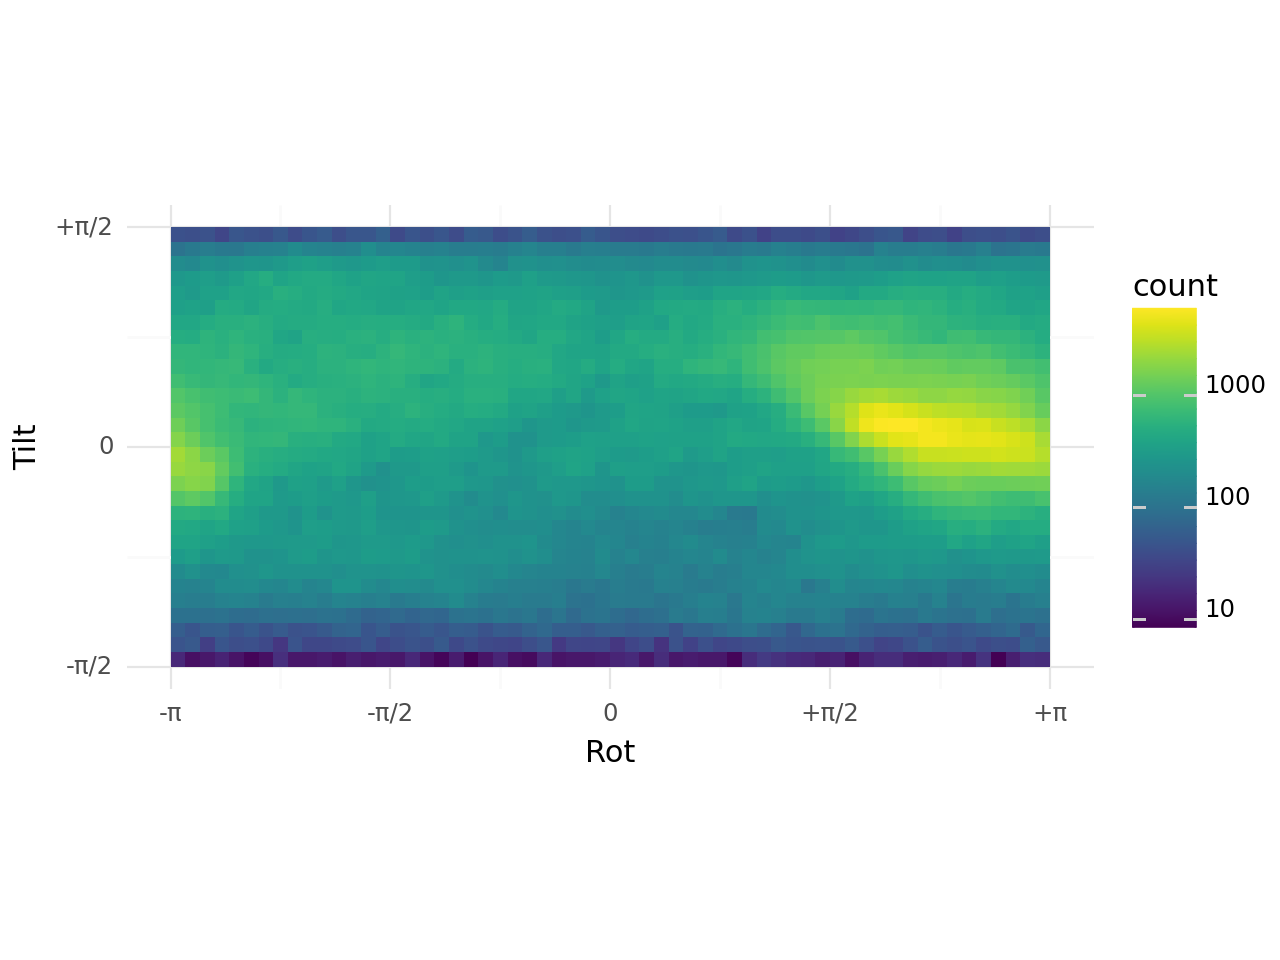

<Figure Size: (640 x 480)>

In [9]:
def make_viewing_dir_plot(dataframe):
    return (
        ggplot(
            dataframe,
            aes(x = 'rot', y = 'tilt')
        )
        + plotnine.theme_minimal()
        + plotnine.geom_bin2d(binwidth = np.pi/number_of_bins)
        + plotnine.coord_fixed()
        + plotnine.scale_fill_cmap(trans = 'log10')
        + plotnine.scale_x_continuous(
            breaks = [-np.pi, -np.pi/2, 0, np.pi/2, np.pi],
            labels = ['-\u03c0', '-\u03c0/2', '0', '+\u03c0/2', '+\u03c0']
        )
        + plotnine.scale_y_continuous(
            breaks = [-np.pi/2, 0, np.pi/2],
            labels = ['-\u03c0/2', '0', '+\u03c0/2',]
        )
        + plotnine.labs(
            x = 'Rot',
            y = 'Tilt'
        )
    )
make_viewing_dir_plot(full_df)

Since we know that the particles look good, next step is to divide them into bins.
The number of bins is defined at the top of the script --- really that should be called
`number_of_bins_per_pi` but that is too wordy. In any case, here we use twice as many bins
in rot because it's twice as wide as tilt, and we want the bins to be square.

In [10]:
full_df['binned_rot'] = pd.cut(full_df['rot'], bins = 2 * number_of_bins)
full_df['binned_tilt'] = pd.cut(full_df['tilt'], bins = number_of_bins)
full_df['joined_bin'] = [f"{full_df['binned_rot'][i]}.{full_df['binned_tilt'][i]}" for i in range(full_df.shape[0])]

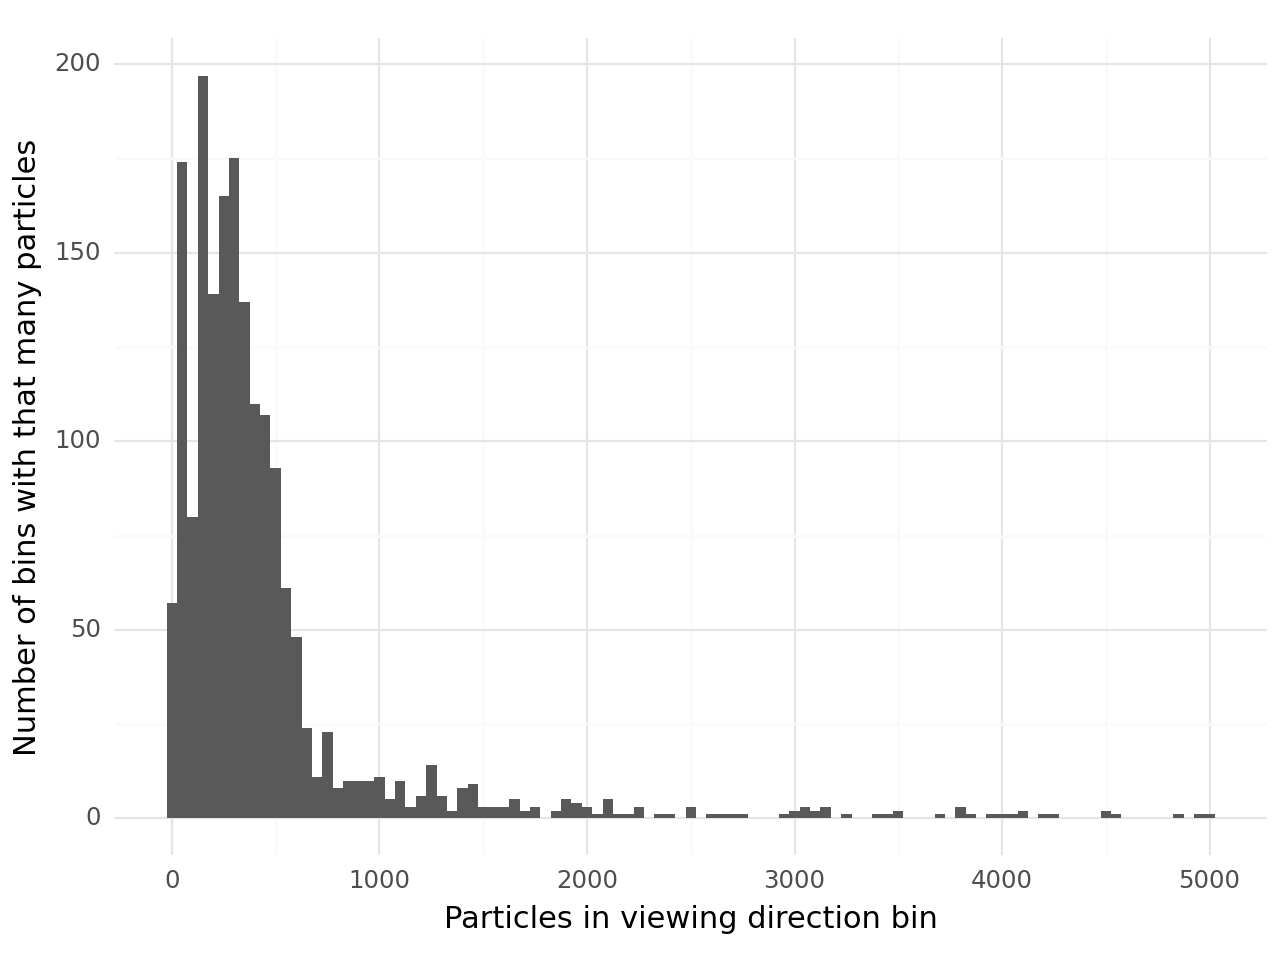

<Figure Size: (640 x 480)>

In [11]:
def make_distribution_plot(dataframe):
    return (
    ggplot(
        pd.DataFrame(dataframe['joined_bin'].value_counts()),
        aes('count')
    )
    + plotnine.geom_histogram(binwidth = 50)
    + plotnine.theme_minimal()
    + plotnine.labs(
        x = 'Particles in viewing direction bin',
        y = 'Number of bins with that many particles'
    )
)
make_distribution_plot(full_df)

Now we define a threshold. This can be done with a function, as here, or with a number (i.e., only allow bins to have at most 1000 particles would be `threshold = 1000`). The threshold must be an integer because of how `DataFrame.sample()` works.

Filtering so that bins contain at most 451 particles.


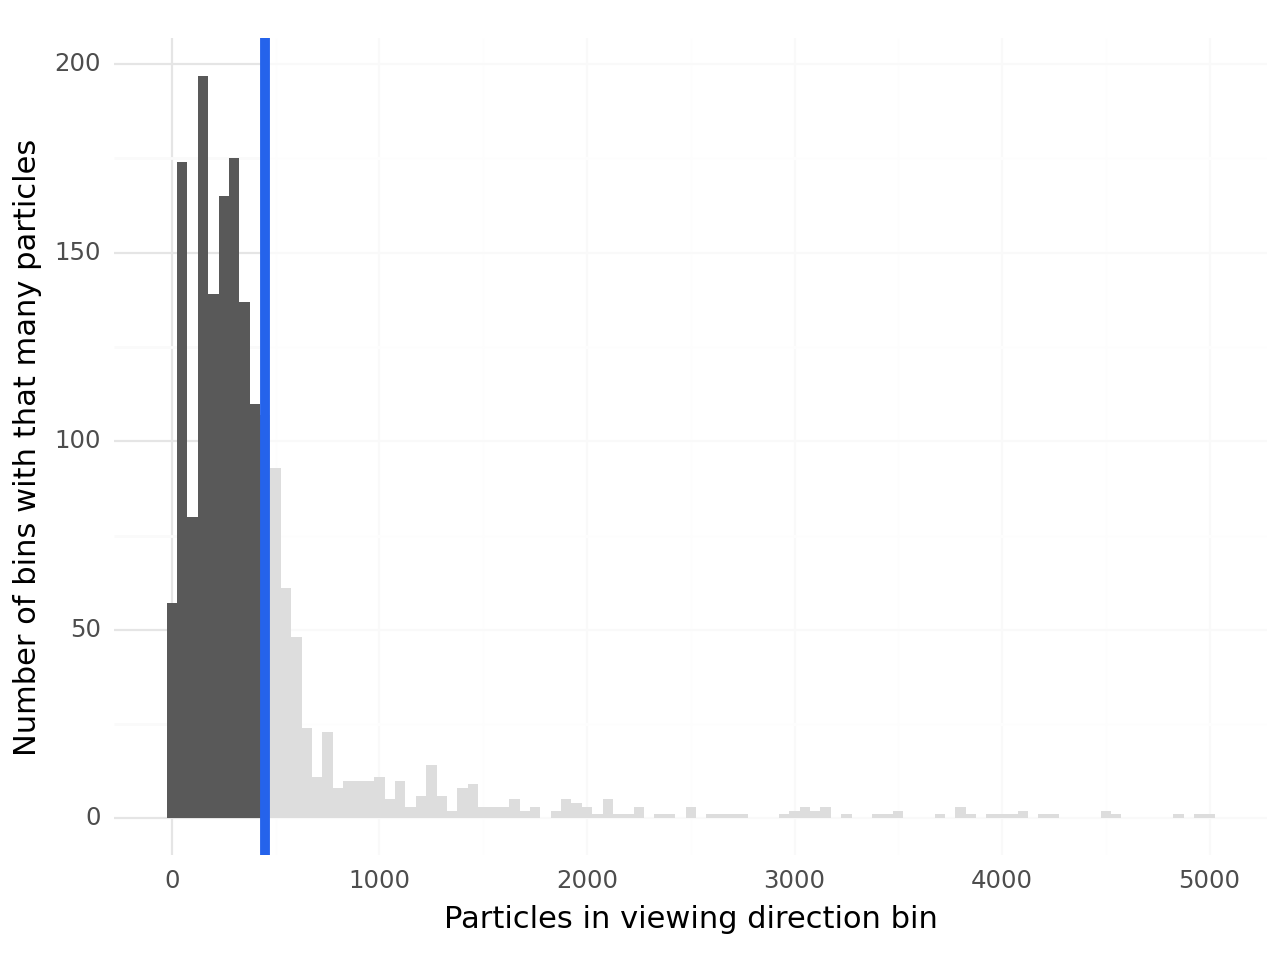

<Figure Size: (640 x 480)>

In [43]:
threshold = int(np.mean(full_df['joined_bin'].value_counts()))
print(f"Filtering so that bins contain at most {threshold} particles.")

(
    make_distribution_plot(full_df)
    + plotnine.annotate(
        geom = 'rect',
        xmin = threshold,
        xmax = np.inf,
        ymin = -np.inf,
        ymax = np.inf,
        fill = '#FFFFFFCC'
    )
    + plotnine.geom_vline(
        xintercept = threshold,
        size = 2,
        color = '#2563eb'
    )
)

/u/rposert/miniconda3/envs/cs-tools/lib/python3.12/site-packages/plotnine/scales/scales.py:50: PlotnineWarning: Scale for 'fill' is already present.
Adding another scale for 'fill',
which will replace the existing scale.



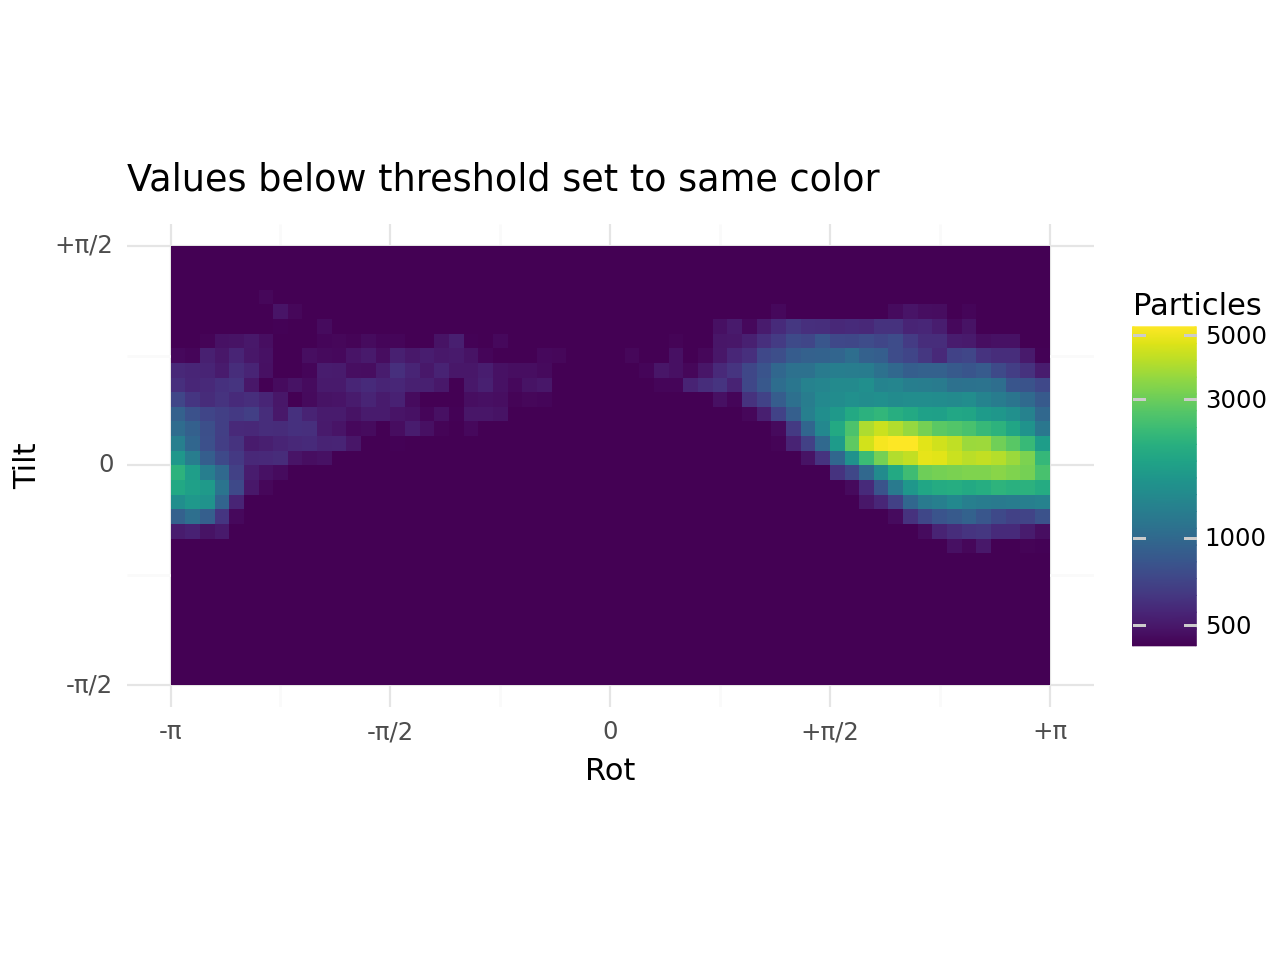

<Figure Size: (640 x 480)>

In [44]:
(
    make_viewing_dir_plot(full_df)
    + plotnine.scale_fill_cmap(
        limits = [threshold, max(full_df['joined_bin'].value_counts())],
        trans = 'log10'
    )
    + plotnine.labs(
        fill = 'Particles',
        title = 'Values below threshold set to same color'
    )
)

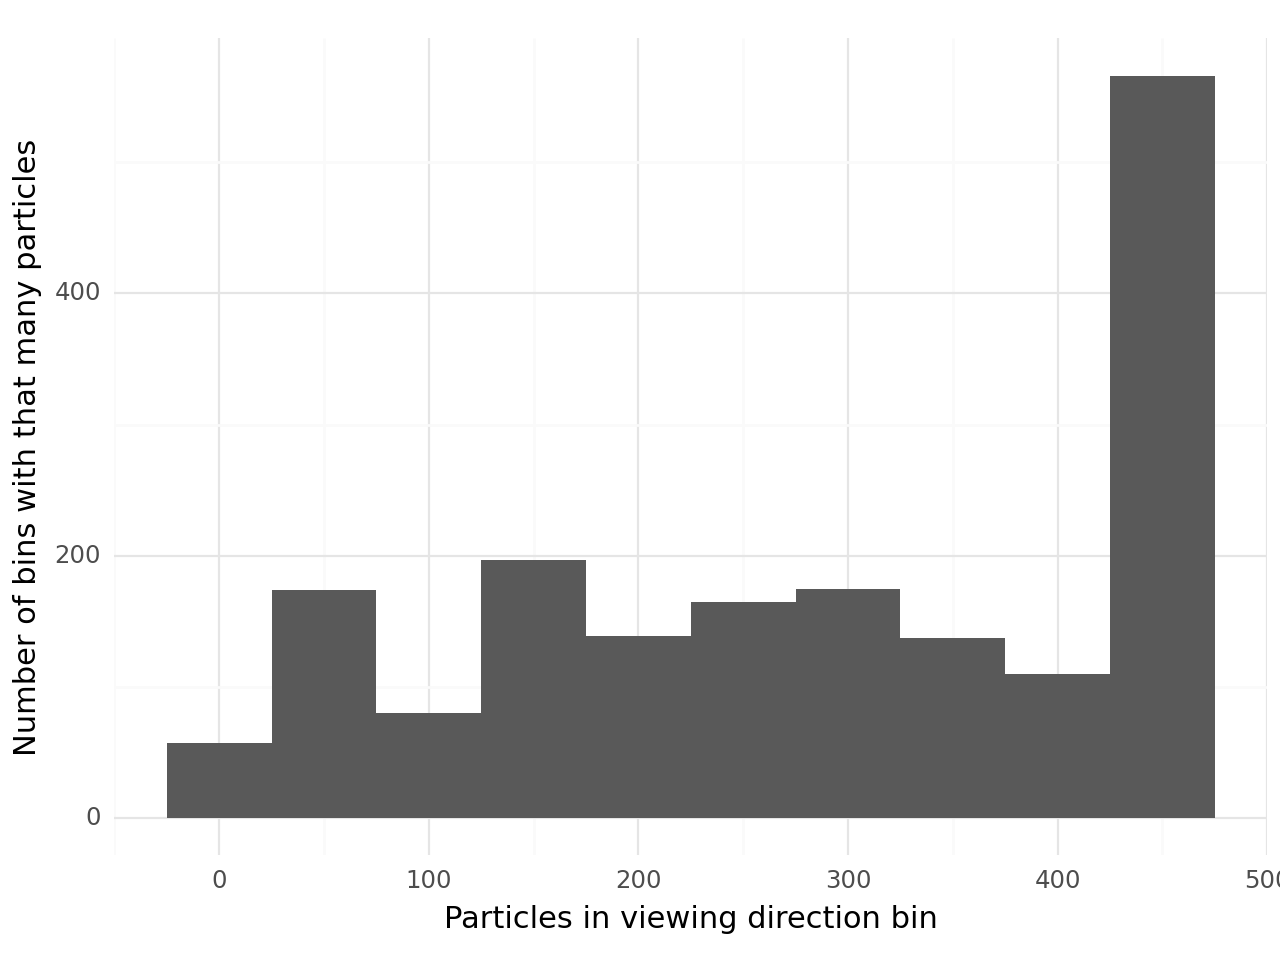

In [24]:
def filter_table(df):
    return df.sample(min(threshold, df.shape[0]))

filtered = full_df.groupby('joined_bin').apply(filter_table)
make_distribution_plot(filtered).draw()

OK, let's plot their orientations to see if it did what we expected/wanted

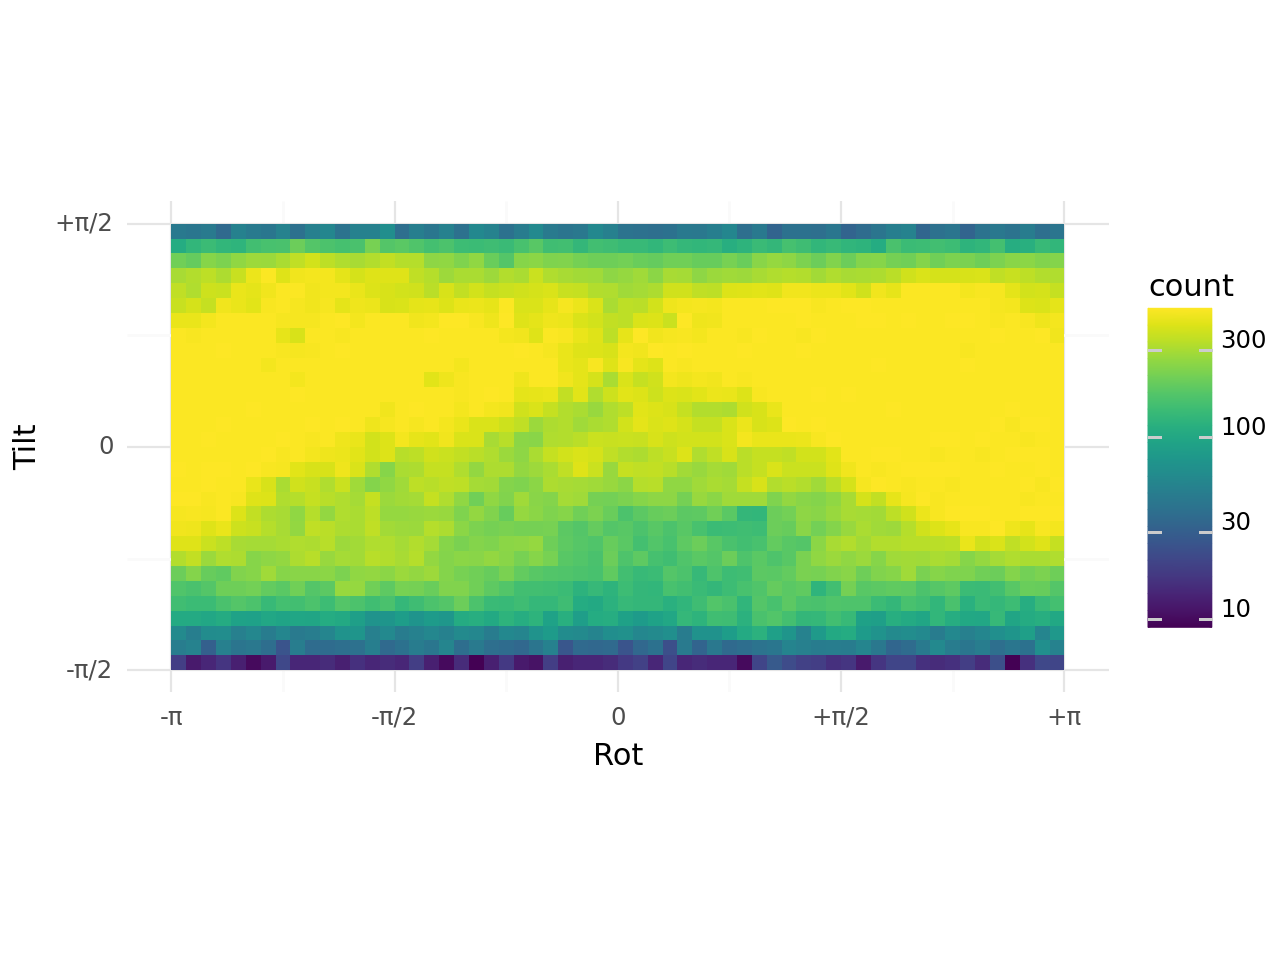

<Figure Size: (640 x 480)>

In [34]:
make_viewing_dir_plot(filtered)

Now to load everything back to CryoSPARC, we filter the original Dataset object so that only UIDs that are in our filtered dataframe remain, then re-upload that to the specified workspace.

In [36]:
filtered_dataset = particles.query({'uid': filtered['uid']})
project.save_external_result(
    workspace_number,
    filtered_dataset,
    type = 'particle',
    name = 'particles',
    passthrough = (job_number, 'particles'),
    title = 'Orientation filtered'
)

'J164'